#### NanoSight Analysis

alexjinich@gmail.com |
Data must be BIDS-formatted & ExperimentSummary be the sole CSV in dir structure (see readme) | 11.22

If you are missing a package use > pip install pkg on Terminal with same kernel

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bids
import seaborn as sns
from pathlib import Path
import pingouin as pg

Load data and construct % particle distribution dataframe (all runs, sessions, subjects)

In [6]:
# Load file structure
path = Path("/home/aljinich/Nanosight/rawdata")   # replace with raw data folder path
save = Path("/home/aljinich/Nanosight")           # replace with results folder path
layout = bids.BIDSLayout(path,validate=False)
subjects = layout.get_subjects()
sessions = layout.get_sessions()
runs = layout.get_runs()

In [7]:
print('Subjects:'); print(subjects)
print('Sessions:'); print(sessions)
print('Runs:'); print(runs)
# check that sub, ses, and run labels printed correctly; otherwise check directory for proper BIDS format and directory path

Subjects:
['4099', '4013', '4018', '213', '4014', '2119', '4005', '1580', '4020', '1402', '4025', '4024', '4017', '4023', '4021', '4026', '4027', '4022', '4015', '4019', '214', '1960', '4016']
Sessions:
['mid', 'pre', 'post']
Runs:
[1, 2, 3, 4]


In [8]:
# Create run-level DF
index_labels = ['20-40','40-60','60-80','80-100','100-120','120-140','140-160','160-180','180-200','>200'] # Particle size categories
ses_data = pd.DataFrame(columns=runs, index=index_labels)

In [9]:
# Loop through all subjects, sessions, and runs, create subject-session sum to get run-total # of particles per size for each subject-session pair, store in df
df = pd.DataFrame()
for sub in subjects:
    for session in sessions:
        ses = ses_data.copy()
        for run in runs:
            # id = str(sub) + '_' + session + '_' + str(run)
            csv_file = layout.get(subject=sub, session=session, run=run, extension='csv', return_type='file') #load csv
            if csv_file != []:
                run_data = pd.read_csv(csv_file[0], skiprows=88, usecols=range(7))[:-103]
                ses.at['20-40',run] = run_data['Concentration average'][20:40].sum()
                ses.at['40-60',run] = run_data['Concentration average'][40:60].sum()
                ses.at['60-80',run] = run_data['Concentration average'][60:80].sum()
                ses.at['80-100',run] = run_data['Concentration average'][80:100].sum()
                ses.at['100-120',run] = run_data['Concentration average'][100:120].sum()
                ses.at['120-140',run] = run_data['Concentration average'][120:140].sum()
                ses.at['140-160',run] = run_data['Concentration average'][140:160].sum()
                ses.at['160-180',run] = run_data['Concentration average'][160:180].sum()
                ses.at['180-200',run] = run_data['Concentration average'][180:200].sum()
                ses.at['>200',run] = run_data['Concentration average'][200:].sum()
        df=pd.concat([df,pd.DataFrame(ses.mean(axis=1),columns=[f'{sub}_{session}'])], axis=1) #populate
# df

Convert to percentages per particle size, split into >/< 120nm, & convert to long-format

In [10]:
# df100 with % of total particles per size as well as % of 20-120nm and 120->200nm (last 2 rows)
df100 = pd.DataFrame()
for col in df.columns.to_list():
    if df[col].isnull().all(0) == False:
        df100[col] = (df[col] / df[col].sum()) * 100 #% per category
        df100.at['20-120%',col] = df100[col][0:5].sum() #sum% 20-120 
        df100.at['120->200%',col] = df100[col][5:10].sum() #sum% 120->200
    else:
        df100.at['20-120%',col] = np.nan #keep nan
        df100.at['120->200%',col] = np.nan
# df100

In [11]:
# long-format df_exo_long with only % of 20-120nm and % >120nm
df_exo = df100.tail(2)
df_exo.insert(0, "size", ['20-120nm', '120->200nm'], True) #add id col
df_exo_long = df_exo.melt(id_vars="size", value_vars=df.columns.to_list(), var_name='sub_ses', value_name='%') #long
df_exo_long['sub'] = df_exo_long.apply(lambda row: row.sub_ses.split('_',1)[0], axis=1)
df_exo_long['ses'] = df_exo_long.apply(lambda row: row.sub_ses.split('_',1)[-1], axis=1) #split sub & ses
del df_exo_long['sub_ses']
df_exo_long = df_exo_long[['sub','ses','size','%']] #reorder cols
# df_exo_long

In [12]:
# long-format for all % size categories
df100.insert(0,"size", df100.index.to_list(), True)
df100_long = df100.head(10).melt(id_vars="size", value_vars=df100.columns.to_list(), var_name='sub_ses', value_name='%') #long
df100_long['sub'] = df100_long.apply(lambda row: row.sub_ses.split('_',1)[0], axis=1)
df100_long['ses'] = df100_long.apply(lambda row: row.sub_ses.split('_',1)[-1], axis=1) #split sub & ses
del df100_long['sub_ses']
df100_long = df100_long[['sub','ses','size','%']] #reorder cols
# df100_long

#### Plots & Stats Tests

1. Split Btw 20-120 and 120+ nm

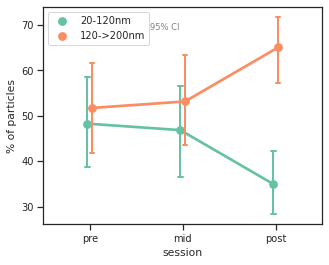

In [13]:
sns.set_theme(style="ticks", palette="Set2", font_scale=.9)
fig, ax = plt.subplots(figsize=(5, 4))
sns.pointplot(data=df_exo_long, x='ses', y='%', hue='size', 
             order=['pre','mid','post'], errorbar=("ci", 95), errwidth=2, capsize=.05, join=True, dodge=True)  # edit order based on # & name of sessions
ax.set_xlabel('session'); ax.set_ylabel('% of particles'); ax.legend().set_title('')
plt.text(.65,69, "95% CI", horizontalalignment='left', size='small', color='grey')

save.joinpath("figures").mkdir(exist_ok=True)
plt.savefig(f'{save}/figures/exosomes_by_session.png', dpi=300, facecolor='white')

In [14]:
# t-tests (between=particle-size, within=session)
pg.pairwise_tests(data=df_exo_long, dv='%', between='size', within='ses', subject='sub', parametric=True, marginal=True, alpha=0.05, alternative='two-sided', 
                padjust='none', effsize='cohen', correction='auto', nan_policy='listwise', return_desc=False, interaction=True, within_first=True)

,Contrast,ses,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,ses,-,mid,post,True,True,-0.565685,16.0,two-sided,0.579455,0.287,0.000000
1,ses,-,mid,pre,True,True,1.460593,16.0,two-sided,0.163485,0.611,0.000000
2,ses,-,post,pre,True,True,1.851640,16.0,two-sided,0.082622,1.003,0.000000
3,size,-,120->200nm,20-120nm,False,True,3.370099,32.0,two-sided,0.001975,17.908,1.155934
4,ses * size,mid,120->200nm,20-120nm,False,True,0.889410,32.0,two-sided,0.380420,0.446,0.305065
5,ses * size,post,120->200nm,20-120nm,False,True,5.988716,32.0,two-sided,0.000001,1.098e+04,2.054113
6,ses * size,pre,120->200nm,20-120nm,False,True,0.374772,32.0,two-sided,0.710302,0.347,0.128546


2. Particle Size Distribution 

In [15]:
df100_long_mean = df100_long.groupby(['ses','size'], sort=False).mean().reset_index()
# df100_long_mean

In [16]:
# t-tests (within=sessions), show only p<.05 
ttall = pd.DataFrame()
for size in enumerate(df100.index[:-2].to_list()):
    tt = pg.pairwise_tests(data=df100_long.loc[df100_long['size']==size[1],:], dv='%', within='ses', subject='sub', parametric=True, marginal=True, alpha=0.05, alternative='two-sided', 
                padjust='none', effsize='cohen', correction='auto', nan_policy='listwise', return_desc=False, interaction=True, within_first=True)
    for contrast in [0,1,2]:
        if tt.loc[contrast,'p-unc'] < 0.05:
            sigt = pd.DataFrame(tt.loc[contrast,:]).T
            sigt.insert(0,'Size',size[1])
            sigt.insert(0,'index',size[0])
            ttall = pd.concat([ttall,sigt],axis=0)
# significance asterisks
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return ""
ttall['sig'] = ttall['p-unc'].apply(convert_pvalue_to_asterisks)
ttall.reset_index(inplace=True)
ttall

,level_0,index,Size,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen,sig
0,2,1,40-60,ses,post,pre,True,True,-2.340978,16.0,two-sided,0.032511,2.064,-0.695887,*
1,0,2,60-80,ses,mid,post,True,True,2.201284,16.0,two-sided,0.04274,1.663,0.801876,*
2,2,2,60-80,ses,post,pre,True,True,-3.528457,16.0,two-sided,0.002791,15.691,-0.952678,**
3,0,9,>200,ses,mid,post,True,True,-2.882193,16.0,two-sided,0.010834,5.031,-0.961269,*
4,2,9,>200,ses,post,pre,True,True,2.325182,16.0,two-sided,0.03354,2.013,0.682963,*


In [17]:
# repeat t-tests removing larger sig value per particle size for plotting 1 sig asterisk per particle size (x tick)
ttall = pd.DataFrame()
for size in enumerate(df100.index[:-2].to_list()):
    tt = pg.pairwise_tests(data=df100_long.loc[df100_long['size']==size[1],:], dv='%', within='ses', subject='sub', parametric=True, marginal=True, alpha=0.05, alternative='two-sided', 
                padjust='none', effsize='cohen', correction='auto', nan_policy='listwise', return_desc=False, interaction=True, within_first=True)
    tt = tt.nsmallest(1,'p-unc','first')
    if tt.iat[0,8] < 0.05:
        tt.insert(0,'Size',size[1])
        tt.insert(0,'index',size[0])
        ttall = pd.concat([ttall,tt],axis=0)
ttall['sig'] = ttall['p-unc'].apply(convert_pvalue_to_asterisks)
ttall.reset_index(inplace=True)

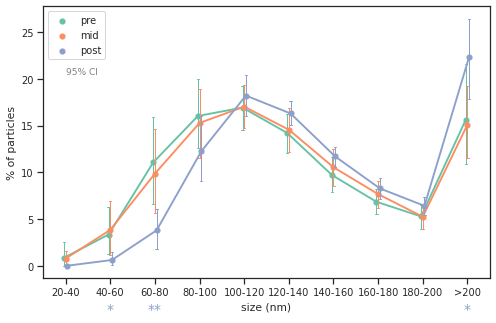

In [24]:
# plot
sns.set_theme(style="ticks", palette="Set2", font_scale=.9)
fig, ax = plt.subplots(figsize=(8, 5))
sns.pointplot(
    data=df100_long, x='size', y='%', hue='ses', hue_order=['pre','mid','post'], scale = .7, 
    errorbar=("ci", 95), capsize=.05, errwidth=1, dodge=True
    )
ax.set_xlabel('size (nm)'); ax.set_ylabel('% of particles'); ax.legend().set_title('')
plt.text(0,20.5, "95% CI", horizontalalignment='left', size='small', color='grey')

for i in ttall.index.to_list():  # add significance asterisks
    plt.text(x=ttall.iloc[i,1], y=-5, s=ttall.iloc[i,14], ha='center', rotation='horizontal', fontsize=14, color='#8da0cb')

save.joinpath("figures").mkdir(exist_ok=True) # save img
plt.savefig(f'{save}/figures/exosomes_by_size.png', dpi=300, facecolor='white')

Export dfs

In [515]:
save.joinpath("exosome_dfs").mkdir(exist_ok=True)
df_exo_long.to_csv(f'{save}/exosome_dfs/exosomes_long.csv') 
df100_long.to_csv(f'{save}/exosome_dfs/percentages_long.csv')